In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def perform_weighted_regression(x, y, dx=None, dy=None, func=None, initial_params=None, fit_type='least_squares'):
    """
    Perform regression analysis with optional uncertainties in x and y.
    
    Parameters:
    -----------
    x : array-like
        Independent variable data
    y : array-like
        Dependent variable data
    dx : array-like, optional
        Uncertainty in x values
    dy : array-like, optional
        Uncertainty in y values
    func : callable
        Model function: f(x, param1, param2, ...)
    initial_params : list, optional
        Initial parameter values
    fit_type : str
        Type of fit ('least_squares' or 'odr' for handling x uncertainties)
        
    Returns:
    --------
    params : array
        Optimized parameters
    pcov : 2D array
        Covariance matrix of parameters
    """
    if fit_type == 'least_squares':
        # Standard least squares with y uncertainties only
        sigma = dy if dy is not None else None
        
        # If initial_params not provided, use ones
        if initial_params is None:
            initial_params = np.ones(func.__code__.co_argcount - 1)
            
        # Perform the fit
        params, pcov = curve_fit(func, x, y, p0=initial_params, sigma=sigma, absolute_sigma=True)
        
    elif fit_type == 'odr':
        # Orthogonal Distance Regression (handles x and y uncertainties)
        from scipy import odr
        
        # Create an ODR model
        model = odr.Model(lambda params, x: func(x, *params))
        
        # Set up data
        if dx is None:
            dx = np.zeros_like(x)
        if dy is None:
            dy = np.ones_like(y)
            
        data = odr.RealData(x, y, sx=dx, sy=dy)
        
        # If initial_params not provided, use ones
        if initial_params is None:
            initial_params = np.ones(func.__code__.co_argcount - 1)
            
        # Create ODR object and run the fit
        odr_obj = odr.ODR(data, model, beta0=initial_params)
        output = odr_obj.run()
        
        params = output.beta
        pcov = output.cov_beta
        
    else:
        raise ValueError("fit_type must be 'least_squares' or 'odr'")
    
    return params, pcov

In [14]:
x = [0.01, 0.5, 1.0, 1.52, 2.03, 2.46, 3.02, 3.5, 4.01, 4.5, 5.0, 5.48, 6.01, 6.52, 6.96, 7.5, 7.99, 8.45, 8.98, 9.48]
y = [9997, 9429, 8667, 8110, 7586, 6986, 6582, 6293, 5748, 5471, 5059, 4824, 4324, 4035, 3826, 3523, 3254, 3251, 2964, 2617]
dx = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
dy = [509.7, 481.3, 443.3, 415.4, 389.1, 359.3, 338.9, 324.3, 297.2, 283.2, 262.6, 250.7, 226.0, 211.6, 201.0, 185.9, 172.6, 171.8, 157.6, 140.7]


Fitted amplitude: 2.1192 ± 0.0000
Fitted decay rate: 0.1000 ± 0.0000


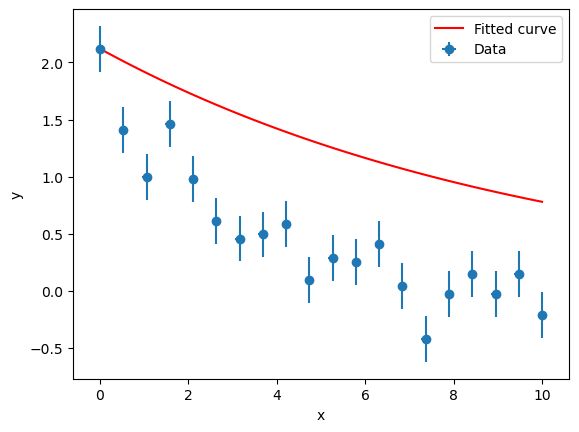

In [2]:

# Example data
x = np.linspace(0, 10, 20)
dx = np.ones_like(x) * 0.1
y = 2 * np.exp(-0.5 * x) + np.random.normal(0, 0.2, len(x))
dy = np.ones_like(y) * 0.2

# Define your model function
def exponential_decay(x, amplitude, decay_rate):
    return amplitude * np.exp(-decay_rate * x)

# Initial parameter guesses
initial_params = [y[0], 0.1]

# Perform the fit
params, pcov = perform_weighted_regression(
    x, y, dx, dy, 
    func=exponential_decay, 
    initial_params=initial_params,
    fit_type='odr'  # Use 'odr' if you have x uncertainties, 'least_squares' otherwise
)

# Extract fitted parameters and uncertainties
fitted_amplitude, fitted_decay = params
amplitude_error, decay_error = np.sqrt(np.diag(pcov))

print(f"Fitted amplitude: {fitted_amplitude:.4f} ± {amplitude_error:.4f}")
print(f"Fitted decay rate: {fitted_decay:.4f} ± {decay_error:.4f}")

# Plotting
plt.errorbar(x, y, xerr=dx, yerr=dy, fmt='o', label='Data')
x_fit = np.linspace(min(x), max(x), 100)
plt.plot(x_fit, exponential_decay(x_fit, *params), 'r-', label='Fitted curve')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()